# Predicting RWGS CO₂ Conversion and CO Selectivity with Multi-Output Random Forest

This notebook demonstrates how to train a multi‐output regressor to predict **X(CO₂)** and **S(CO)** from the reactor operating conditions **Tout**, **pset**, **H₂:CO₂**, and **GHSV**.

---

In [30]:
# In[1]: Imports and Data Loading

import numpy as np
import pandas as pd
from io import StringIO

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

# Raw data as CSV text
csv_data = """\
Tout,pset,H2toCO2,GHSV,xH2,xCH4,xCO,xCO2,XCO2,SCO
981.80,6.00,2.50,8000,63.00,-0.04,28.30,8.38,85.93,98.00
980.00,6.00,2.50,,63.20,0.08,28.50,8.26,86.61,99.48
952.70,6.00,2.50,8000,63.00,0.00,27.70,8.79,84.53,97.12
950.00,6.00,2.50,,63.30,0.14,27.90,8.63,85.23,99.27
949.80,6.00,1.30,8000,41.00,-0.04,36.70,21.90,98.91,6.49
950.00,6.00,1.30,,40.60,0.03,36.60,22.80,98.80,6.30
949.10,6.00,1.30,8000,41.10,-0.04,36.80,21.80,98.91,6.62
950.00,6.00,1.30,,40.60,0.03,36.60,22.80,98.80,6.30
571.22,1.16,3.00,8000,64.40,10.68,8.51,17.19,50.83,42.20
595.01,1.27,3.00,20000,67.00,8.03,10.31,15.45,52.70,52.08
581.07,6.06,3.00,8000,49.22,26.32,4.78,21.11,58.92,14.87
621.86,6.01,3.00,20000,56.70,18.39,7.73,17.96,57.31,28.38
582.21,7.99,3.00,8000,46.27,29.35,4.29,21.59,60.47,12.38
628.62,7.98,3.00,20000,54.75,20.39,7.37,18.29,58.41,25.45
657.29,1.16,3.00,8000,71.09,3.22,14.05,12.17,56.33,74.41
663.16,1.27,3.00,20000,71.10,3.44,13.95,12.09,57.07,71.79
666.81,6.00,3.00,8000,60.61,13.92,9.87,15.98,57.09,40.26
688.14,5.98,3.00,20000,63.48,11.02,11.53,14.24,58.45,48.65
668.38,8.03,3.00,8000,58.28,16.34,9.17,16.65,57.92,34.93
693.78,7.94,3.00,20000,61.84,12.68,11.12,14.62,59.07,44.70
753.01,1.19,3.00,8000,73.47,0.36,17.72,8.91,63.89,86.42
750.11,1.27,3.00,20000,73.45,0.58,17.41,9.07,63.78,84.06
755.83,5.98,3.00,8000,68.77,5.12,15.43,10.81,61.92,69.91
761.19,5.97,3.00,20000,69.08,4.89,15.63,10.59,62.51,70.14
849.99,1.26,3.00,8000,73.32,0.04,19.67,7.36,68.73,88.85
849.68,1.28,3.00,20000,73.46,0.06,19.56,7.37,68.87,87.52
850.43,5.98,3.00,8000,72.40,0.95,19.23,7.69,68.15,85.95
850.68,6.02,3.00,20000,72.41,1.07,19.14,7.70,68.39,84.44
946.43,1.21,3.00,8000,73.00,0.00,21.06,6.27,72.27,89.77
947.99,1.28,3.00,20000,73.14,0.00,21.02,6.23,72.54,88.60
947.15,5.92,3.00,8000,72.83,0.15,21.01,6.31,72.17,89.49
948.54,5.99,3.00,20000,72.99,0.17,20.93,6.27,72.46,87.95
"""

df = pd.read_csv(StringIO(csv_data))
df['GHSV'] = df['GHSV'].fillna(df['GHSV'].median())  # fill missing GHSV


In [31]:
# In[2]: Prepare features and targets, split data

# Features: Tout, pset, H2toCO2, GHSV
X = df[['Tout','pset','H2toCO2','GHSV']].values

# Targets: XCO2 and SCO
y = df[['XCO2','SCO']].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)


In [32]:
# In[3]: Train multi-output Random Forest and evaluate

# Base regressor
base_rf = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)

# Wrap for multi-output
model = MultiOutputRegressor(base_rf)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Compute RMSE for each target
rmse_xco2 = np.sqrt(mean_squared_error(y_test[:,0], y_pred[:,0]))
rmse_sco  = np.sqrt(mean_squared_error(y_test[:,1], y_pred[:,1]))
print(f"RMSE X(CO₂): {rmse_xco2:.2f} %")
print(f"RMSE S(CO) : {rmse_sco:.2f} %")


RMSE X(CO₂): 0.46 %
RMSE S(CO) : 4.08 %


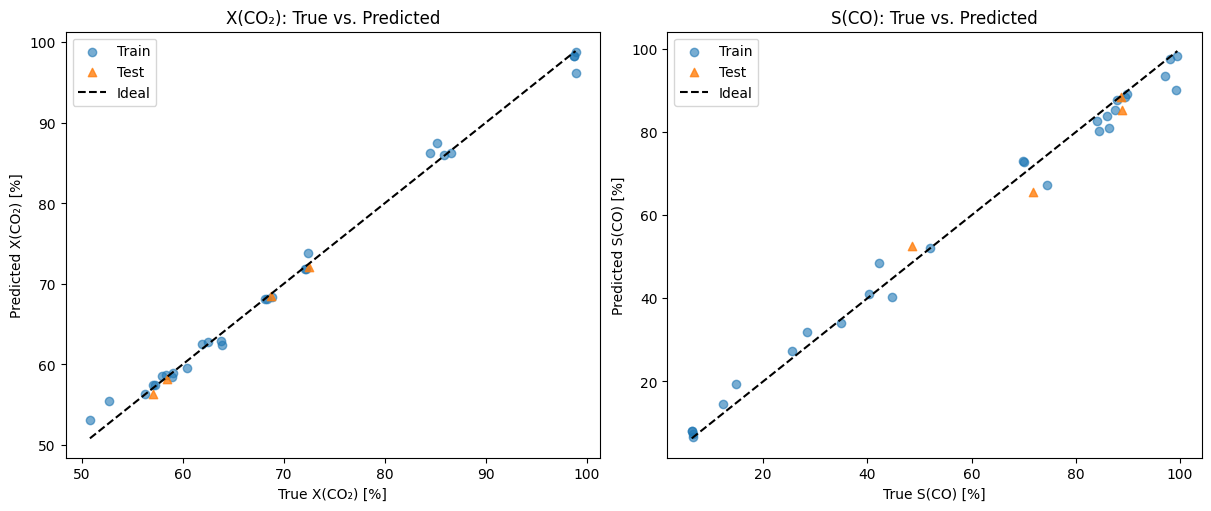

In [33]:
# In[4]: Plot true vs. predicted for both train and test sets

# Predict on training set as well
y_train_pred = model.predict(X_train)

fig, axes = plt.subplots(1, 2, figsize=(12,5), constrained_layout=True)

# --- X(CO2) ---
# Training data
axes[0].scatter(y_train[:,0], y_train_pred[:,0],
                color='C0', marker='o', alpha=0.6, label='Train')
# Test data
axes[0].scatter(y_test[:,0], y_pred[:,0],
                color='C1', marker='^', alpha=0.8, label='Test')
# 1:1 reference line
min_val = min(y_train[:,0].min(), y_test[:,0].min())
max_val = max(y_train[:,0].max(), y_test[:,0].max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'k--', label='Ideal')
axes[0].set_title('X(CO₂): True vs. Predicted')
axes[0].set_xlabel('True X(CO₂) [%]')
axes[0].set_ylabel('Predicted X(CO₂) [%]')
axes[0].legend()

# --- S(CO) ---
# Training data
axes[1].scatter(y_train[:,1], y_train_pred[:,1],
                color='C0', marker='o', alpha=0.6, label='Train')
# Test data
axes[1].scatter(y_test[:,1], y_pred[:,1],
                color='C1', marker='^', alpha=0.8, label='Test')
# 1:1 reference line
min_val2 = min(y_train[:,1].min(), y_test[:,1].min())
max_val2 = max(y_train[:,1].max(), y_test[:,1].max())
axes[1].plot([min_val2, max_val2], [min_val2, max_val2], 'k--', label='Ideal')
axes[1].set_title('S(CO): True vs. Predicted')
axes[1].set_xlabel('True S(CO) [%]')
axes[1].set_ylabel('Predicted S(CO) [%]')
axes[1].legend()

plt.show()



# In[5]: SHAP Analysis with Full Train & Test Coverage

Below we compute SHAP values for **all** samples (train+test) and visualize:

1. **Beeswarm**: full distribution of impacts per feature.  
2. **Bar**: mean absolute SHAP values to rank features.  
3. **Dependence scatter**: how the top feature influences the output


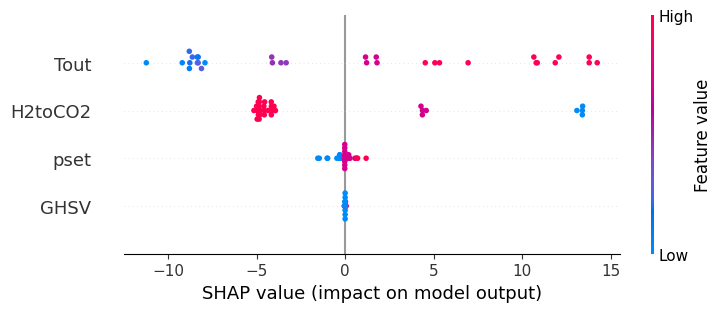

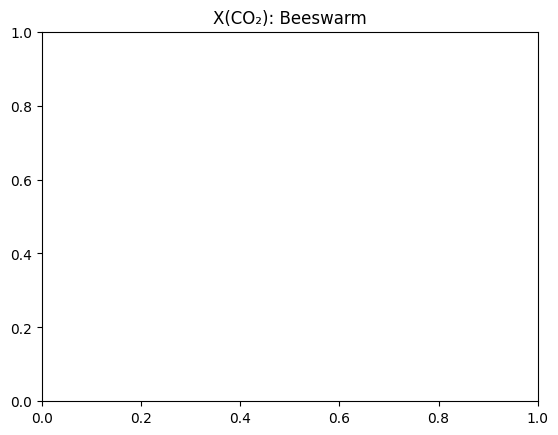

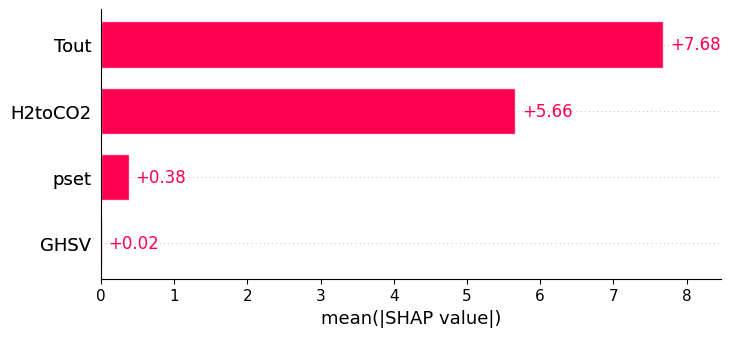

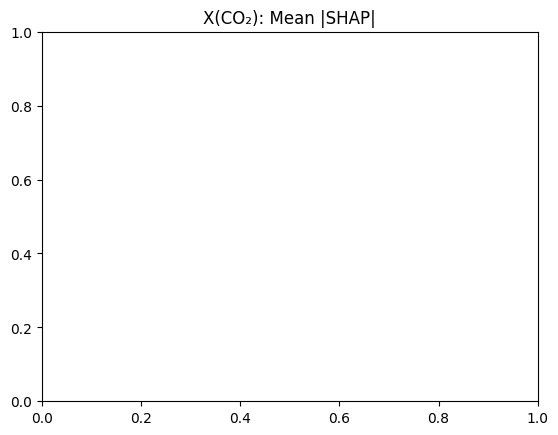

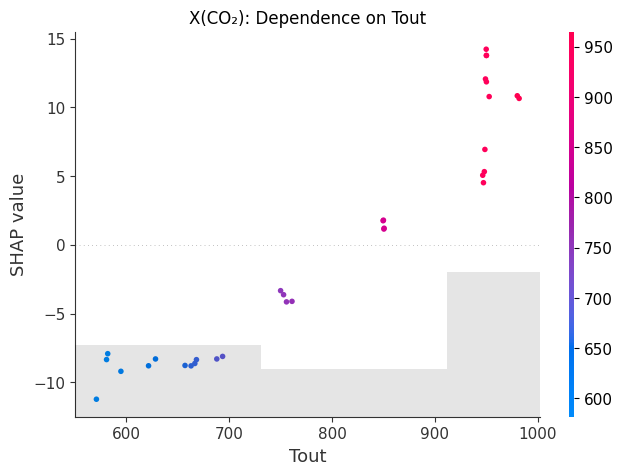

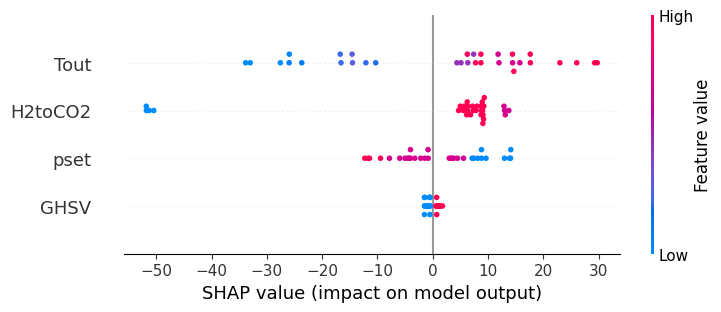

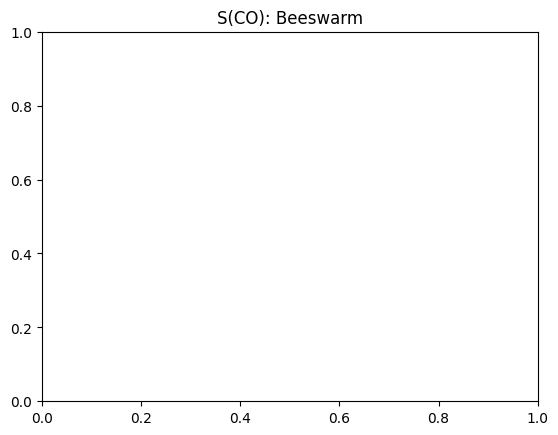

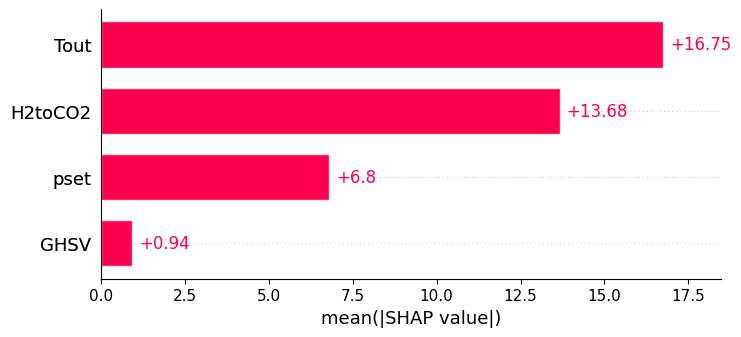

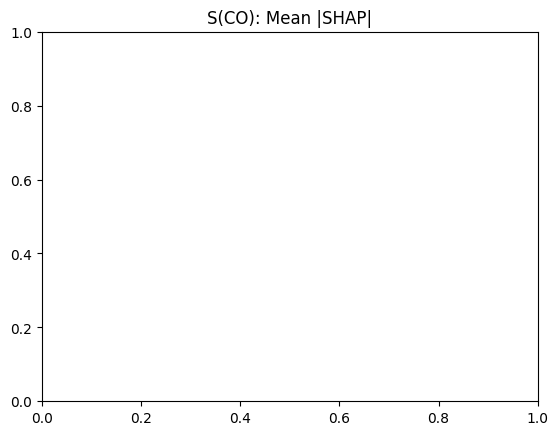

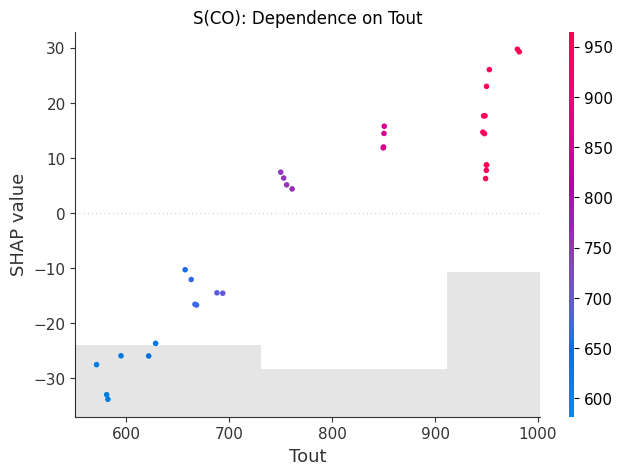

In [34]:
# In[5]: Improved SHAP Analysis

import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Combine train+test features
X_all = np.vstack([X_train, X_test])
feature_names = ['Tout','pset','H2toCO2','GHSV']
df_all = pd.DataFrame(X_all, columns=feature_names)

# Function to plot for a single estimator
def plot_shap_for_target(estimator, title_prefix):
    # Compute SHAP values
    explainer = shap.TreeExplainer(estimator)
    shap_vals = explainer.shap_values(df_all)
    # Create Explanation object
    expl = shap.Explanation(values=shap_vals,
                            data=df_all.values,
                            feature_names=feature_names)
    
    # Beeswarm
    shap.plots.beeswarm(expl)
    plt.title(f'{title_prefix}: Beeswarm')
    plt.show()
    
    # Bar chart of mean |SHAP|
    shap.plots.bar(expl)
    plt.title(f'{title_prefix}: Mean |SHAP|')
    plt.show()
    
    # Dependence on top feature
    mean_abs = np.abs(shap_vals).mean(axis=0)
    top_idx = mean_abs.argmax()
    top_feat = feature_names[top_idx]
    
    shap.plots.scatter(
        expl[:, top_idx],
        color=expl.data[:, top_idx],
        show=False
    )
    plt.title(f'{title_prefix}: Dependence on {top_feat}')
    plt.xlabel(top_feat)
    plt.ylabel('SHAP value')
    plt.show()

# Plot for X(CO2) (first estimator)
plot_shap_for_target(model.estimators_[0], 'X(CO₂)')

# Plot for S(CO) (second estimator)
plot_shap_for_target(model.estimators_[1], 'S(CO)')
